<a href="https://colab.research.google.com/github/Ramajayam1325/AI_MODEL_FISH/blob/main/AI_MODEL_FISH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sripaadsrinivasan/fish-species-image-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fish-species-image-data' dataset.
Path to dataset files: /kaggle/input/fish-species-image-data


In [17]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/akashguna/fish-detection-dataset/versions/1"
for root, dirs, files in os.walk(dataset_path):
    for f in files:
        print(os.path.join(root, f))


In [18]:
import os

base_path = "/kaggle/input/fish-species-image-data/Fish_Data/images"

# Look at first level
print("Contents of dataset root:", os.listdir(base_path))

# Drill one level deeper (first folder)
first_sub = os.path.join(base_path, os.listdir(base_path)[0])
print("First subfolder:", first_sub)
print("Contents:", os.listdir(first_sub)[:10])


Contents of dataset root: ['raw_images', 'numbered', 'cropped']
First subfolder: /kaggle/input/fish-species-image-data/Fish_Data/images/raw_images
Contents: ['epinephelus_areolatus_13.jpg', 'paracaesio_kusakarii_3.jpg', 'oxycheilinus_bimaculatus_5.jpg', 'lethrinus_erythracanthus_7.jpg', 'PQV7DP-S_5.jpg', 'aphareus_furca_9.jpg', 'pristipomoides_argyrogrammicus_4.jpg', 'carangoides_fulvoguttatus_2.jpg', 'choerodon_cyanodus_7.jpg', 'parastromateus_niger_3.jpg']


In [19]:
import os

images_path = "/kaggle/input/fish-species-image-data/Fish_Data/images"
print("Images folder contents:", os.listdir(images_path))

# Also check final_all_index.txt
txt_file = "/kaggle/input/fish-species-image-data/Fish_Data/final_all_index.txt"
with open(txt_file, "r") as f:
    lines = f.readlines()

print("First 10 lines of final_all_index.txt:")
for line in lines[:10]:
    print(line.strip())


Images folder contents: ['raw_images', 'numbered', 'cropped']
First 10 lines of final_all_index.txt:
1=A73EGS-P=controlled=A73EGS-P_1=1
1=A73EGS-P=sketches=A73EGS-P_2=2
1=A73EGS-P=controlled=A73EGS-P_3=3
1=A73EGS-P=controlled=A73EGS-P_4=4
1=A73EGS-P=controlled=A73EGS-P_5=5
1=A73EGS-P=controlled=A73EGS-P_6=6
1=A73EGS-P=controlled=A73EGS-P_7=7
2=acanthaluteres_brownii=insitu=acanthaluteres_brownii_1=8
2=acanthaluteres_brownii=insitu=acanthaluteres_brownii_2=9
2=acanthaluteres_brownii=insitu=acanthaluteres_brownii_3=10


Total images found with labels: 4396


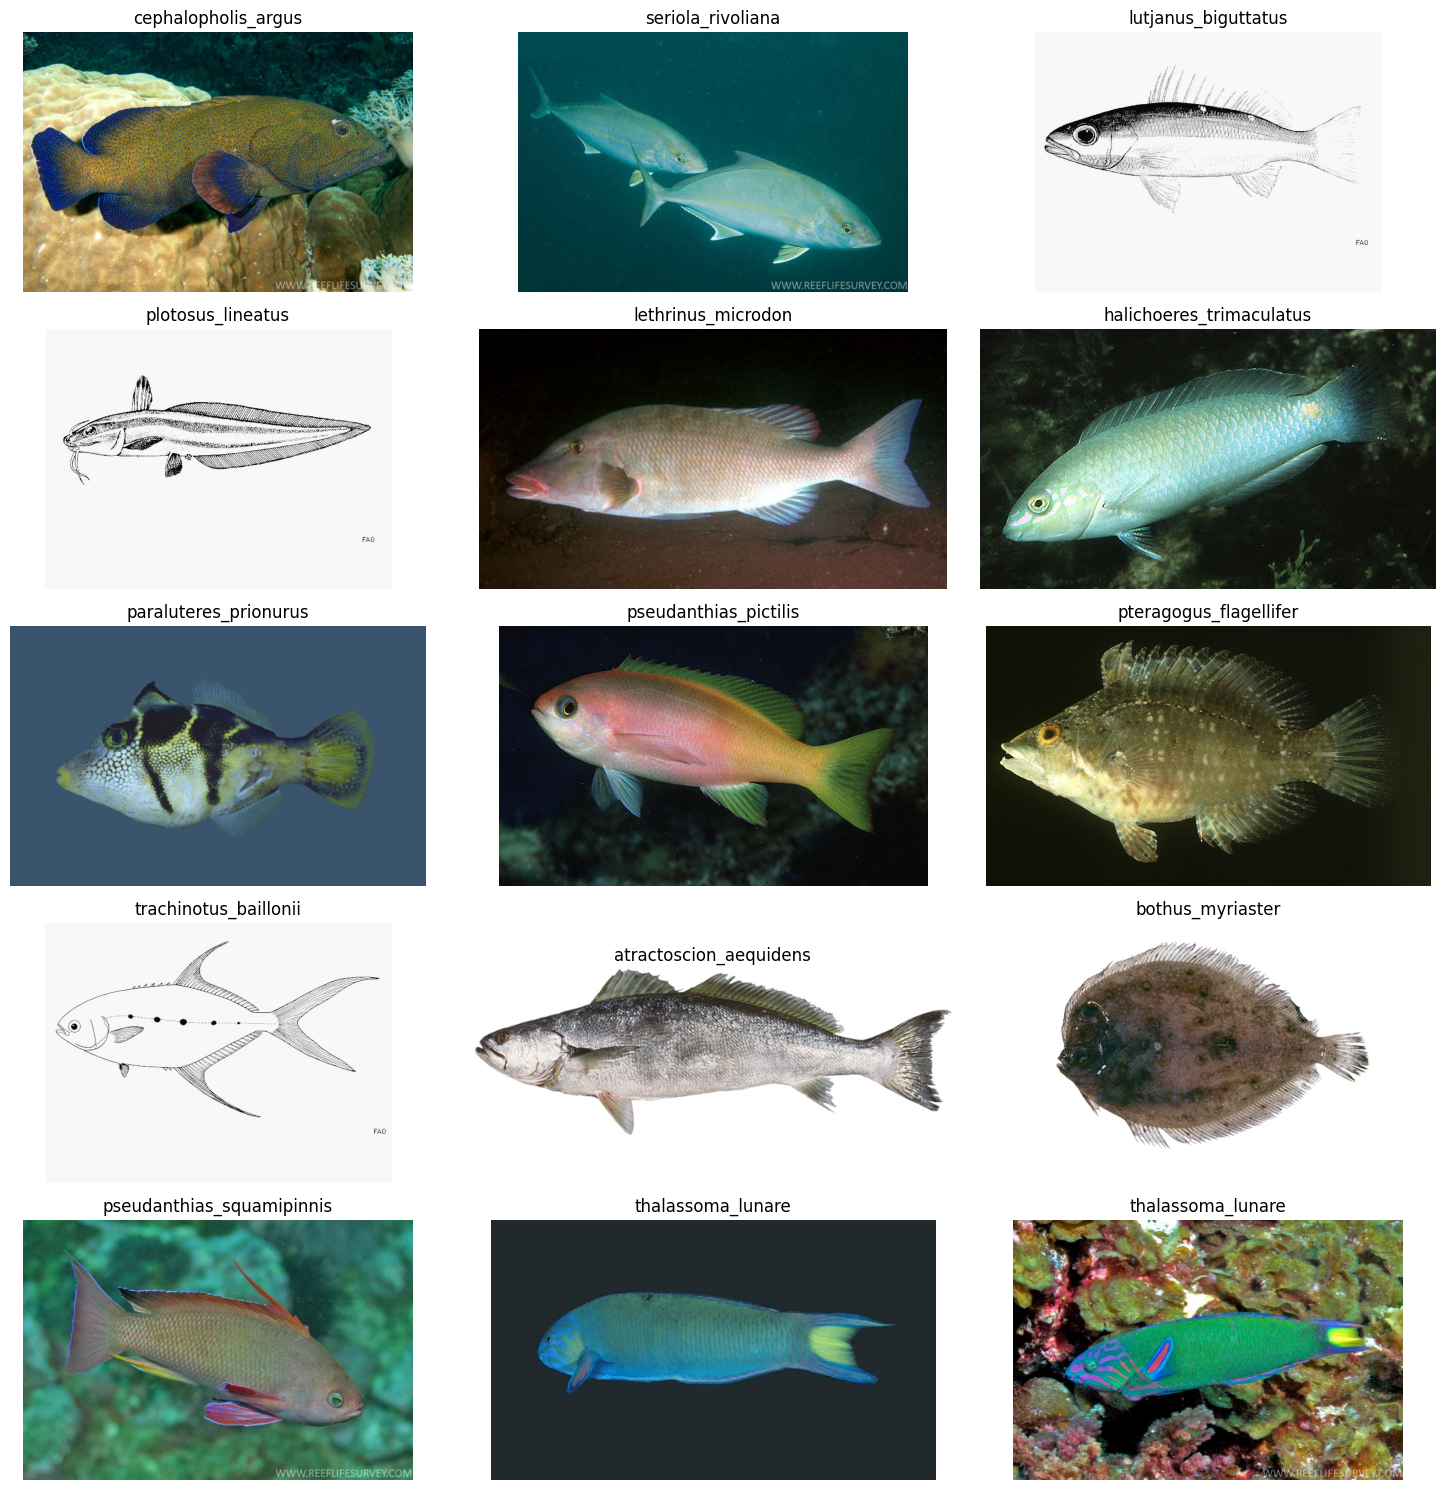

In [15]:
import os
import random
import matplotlib.pyplot as plt
import cv2

# Paths
base_path = "/kaggle/input/fish-species-image-data/Fish_Data"
images_dir = os.path.join(base_path, "images", "raw_images")
index_file = os.path.join(base_path, "final_all_index.txt")

# Parse final_all_index.txt to get filename → class mapping
filename_to_class = {}
with open(index_file, "r") as f:
    for line in f:
        parts = line.strip().split("=")
        if len(parts) >= 5:
            _, cls_name, _, fname, _ = parts
            # images might have .JPG or .jpg extension
            for ext in [".JPG", ".jpg", ".png"]:
                full_path = os.path.join(images_dir, fname + ext)
                if os.path.exists(full_path):
                    filename_to_class[full_path] = cls_name
                    break

print(f"Total images found with labels: {len(filename_to_class)}")

# Pick 15 random samples
samples = random.sample(list(filename_to_class.keys()), min(15, len(filename_to_class)))

# Plot images
plt.figure(figsize=(15, 15))

for idx, img_path in enumerate(samples):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cls_name = filename_to_class[img_path]

    plt.subplot(5, 3, idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(cls_name)

plt.tight_layout()
plt.show()


In [20]:
# Cell 1 — basic imports & dataset path
import os
import glob
import xml.etree.ElementTree as ET
import random
import shutil
from pathlib import Path

# Path where kagglehub extracted your dataset
SRC_TRAIN = "/root/.cache/kagglehub/datasets/akashguna/fish-detection-dataset/versions/1/train"

# Target workspace in Colab
WORK = "/content/fish_dataset"
os.makedirs(WORK, exist_ok=True)

print("Source train folder:", SRC_TRAIN)
print("Working dir:", WORK)


Source train folder: /root/.cache/kagglehub/datasets/akashguna/fish-detection-dataset/versions/1/train
Working dir: /content/fish_dataset


In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import os

# Paths
base_path = "/kaggle/input/fish-species-image-data/Fish_Data"
images_dir = os.path.join(base_path, "images", "raw_images")
index_file = os.path.join(base_path, "final_all_index.txt")

# Parse final_all_index.txt for filename → class mapping
filename_to_class = {}
classes_set = set()

with open(index_file, "r") as f:
    for line in f:
        parts = line.strip().split("=")
        if len(parts) >= 5:
            _, cls_name, _, fname, _ = parts
            classes_set.add(cls_name)
            for ext in [".JPG", ".jpg", ".png"]:
                full_path = os.path.join(images_dir, fname + ext)
                if os.path.exists(full_path):
                    filename_to_class[full_path] = cls_name
                    break

classes = sorted(list(classes_set))
cls2idx = {cls: idx for idx, cls in enumerate(classes)}

print("Classes:", classes)
print("Total images:", len(filename_to_class))

# Define PyTorch Dataset
class FishDataset(Dataset):
    def __init__(self, files, cls2idx, transform=None):
        self.files = files
        self.cls2idx = cls2idx
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        label = self.cls2idx[filename_to_class[img_path]]
        return img, label

# Train/val split
all_files = list(filename_to_class.keys())
random.seed(42)
random.shuffle(all_files)
split = int(0.8 * len(all_files))
train_files = all_files[:split]
val_files = all_files[split:]

# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = FishDataset(train_files, cls2idx, transform=transform)
val_dataset = FishDataset(val_files, cls2idx, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


Classes: ['A73EGS-P', 'CUNWCB-Y', 'Istiophorus_platypterus', 'P1ROZC-Z', 'PQV7DP-S', 'acanthaluteres_brownii', 'acanthaluteres_spilomelanurus', 'acanthaluteres_vittiger', 'acanthistius_cinctus', 'acanthopagrus_australis', 'acanthopagrus_berda', 'acanthopagrus_latus', 'achoerodus_gouldii', 'achoerodus_viridis', 'acreichthys_tomentosus', 'aesopia_cornuta', 'aethaloperca_rogaa', 'alectis_ciliaris', 'alectis_indica', 'alepes_kleinii', 'aluterus_monoceros', 'aluterus_scriptus', 'amanses_scopas', 'anampses_caeruleopunctatus', 'anampses_elegans', 'anampses_femininus', 'anampses_geographicus', 'anampses_lennardi', 'anampses_melanurus', 'anampses_meleagrides', 'anampses_neoguinaicus', 'anampses_twistii', 'anodontostoma_chacunda', 'anyperodon_leucogrammicus', 'aphareus_furca', 'aphareus_rutilans', 'aprion_virescens', 'argyrops_spinifer', 'aseraggodes_melanostictus', 'atractoscion_aequidens', 'atule_mate', 'auxis_rochei', 'auxis_thazard', 'bathylagichthys_greyae', 'beryx_decadactylus', 'bodianus_

In [22]:
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))  # number of fish classes
model = model.to(device)


Using device: cpu
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 121MB/s]


In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [24]:
print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))

# Try iterating one batch
for imgs, labels in train_loader:
    print("Batch shape:", imgs.shape, labels.shape)
    break


Number of training batches: 110
Number of validation batches: 28
Batch shape: torch.Size([32, 3, 224, 224]) torch.Size([32])


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [26]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [27]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),  # smaller → faster
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [28]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)


In [29]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)


In [30]:
from torchvision.models import mobilenet_v2

model = mobilenet_v2(weights='IMAGENET1K_V1')
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(classes))
model = model.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 136MB/s]


In [31]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2
import cv2
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cpu


In [32]:
# Paths
base_path = "/kaggle/input/fish-species-image-data/Fish_Data"
images_dir = os.path.join(base_path, "images", "raw_images")
index_file = os.path.join(base_path, "final_all_index.txt")

# Parse filename → class mapping
filename_to_class = {}
classes_set = set()

with open(index_file, "r") as f:
    for line in f:
        parts = line.strip().split("=")
        if len(parts) >= 5:
            _, cls_name, _, fname, _ = parts
            classes_set.add(cls_name)
            for ext in [".JPG", ".jpg", ".png"]:
                full_path = os.path.join(images_dir, fname + ext)
                if os.path.exists(full_path):
                    filename_to_class[full_path] = cls_name
                    break

classes = sorted(list(classes_set))
cls2idx = {cls: idx for idx, cls in enumerate(classes)}
print(f"Found {len(filename_to_class)} images, {len(classes)} classes")


Found 4396 images, 483 classes


In [33]:
class FishDataset(Dataset):
    def __init__(self, files, cls2idx, transform=None):
        self.files = files
        self.cls2idx = cls2idx
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        label = self.cls2idx[filename_to_class[img_path]]
        return img, label

# Train/val split
all_files = list(filename_to_class.keys())
random.seed(42)
random.shuffle(all_files)
split = int(0.8 * len(all_files))
train_files = all_files[:split]
val_files = all_files[split:]

# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),  # smaller for speed
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = FishDataset(train_files, cls2idx, transform=transform)
val_dataset = FishDataset(val_files, cls2idx, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)


In [34]:
# MobileNetV2
model = mobilenet_v2(weights='IMAGENET1K_V1')
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(classes))
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [35]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [36]:
num_epochs = 10
early_stopping = EarlyStopping(patience=3, min_delta=0.001)
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # ---------- Train ----------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in tqdm(train_loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

    # ---------- Validate ----------
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validation"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / total
    val_acc = correct / total
    print(f"Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # ---------- Save Best Model ----------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_fish_model.pth")
        print("Saved best model!")

    # ---------- Early Stopping ----------
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Stopping early at epoch {epoch+1}")
        break



Epoch 1/10


Training: 100%|██████████| 220/220 [03:13<00:00,  1.13it/s]


Train Loss: 5.7454 Acc: 0.0603


Validation: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


Validation Loss: 4.7665 Acc: 0.1625
Saved best model!

Epoch 2/10


Training: 100%|██████████| 220/220 [03:18<00:00,  1.11it/s]


Train Loss: 3.9593 Acc: 0.2986


Validation: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Validation Loss: 3.8268 Acc: 0.3057
Saved best model!

Epoch 3/10


Training: 100%|██████████| 220/220 [03:17<00:00,  1.11it/s]


Train Loss: 2.8486 Acc: 0.4977


Validation: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Validation Loss: 3.1250 Acc: 0.4205
Saved best model!

Epoch 4/10


Training: 100%|██████████| 220/220 [03:21<00:00,  1.09it/s]


Train Loss: 2.0419 Acc: 0.6715


Validation: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Validation Loss: 2.6833 Acc: 0.4761
Saved best model!

Epoch 5/10


Training: 100%|██████████| 220/220 [03:19<00:00,  1.10it/s]


Train Loss: 1.4192 Acc: 0.7984


Validation: 100%|██████████| 55/55 [00:14<00:00,  3.81it/s]


Validation Loss: 2.3871 Acc: 0.5091
Saved best model!

Epoch 6/10


Training: 100%|██████████| 220/220 [03:17<00:00,  1.11it/s]


Train Loss: 0.9599 Acc: 0.8763


Validation: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Validation Loss: 2.1925 Acc: 0.5420
Saved best model!

Epoch 7/10


Training: 100%|██████████| 220/220 [03:24<00:00,  1.08it/s]


Train Loss: 0.6308 Acc: 0.9414


Validation: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Validation Loss: 2.0180 Acc: 0.5534
Saved best model!

Epoch 8/10


Training: 100%|██████████| 220/220 [03:21<00:00,  1.09it/s]


Train Loss: 0.4065 Acc: 0.9721


Validation: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Validation Loss: 1.9924 Acc: 0.5602
Saved best model!

Epoch 9/10


Training: 100%|██████████| 220/220 [03:19<00:00,  1.10it/s]


Train Loss: 0.2708 Acc: 0.9869


Validation: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Validation Loss: 1.9189 Acc: 0.5659
Saved best model!

Epoch 10/10


Training: 100%|██████████| 220/220 [03:25<00:00,  1.07it/s]


Train Loss: 0.1871 Acc: 0.9920


Validation: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]

Validation Loss: 1.8869 Acc: 0.5750
Saved best model!


In [37]:

# Using pretrained CLIP or ResNet for image analysis
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms

class ImageAnalyzer:
    def __init__(self):
        self.model = models.resnet50(pretrained=True)
        self.model.eval()

    def analyze_image(self, image_path):
        # Extract features and basic analysis
        pass


In [38]:
import requests

class DeepSeekIntegration:
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://api.deepseek.com/v1/chat/completions"

    def generate_explanation(self, image_analysis):
        # Create prompt combining vision analysis
        prompt = f"""
        Based on this image analysis: {image_analysis}
        Provide a clear, human-readable explanation of what's in the image.
        """

        response = requests.post(self.base_url, headers={
            "Authorization": f"Bearer {self.api_key}"
        }, json={
            "model": "deepseek-chat",
            "messages": [{"role": "user", "content": prompt}]
        })
        return response.json()["choices"][0]["message"]["content"]

In [39]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 63.1 MB/s eta 0:00:00


In [40]:
import streamlit as st
import tempfile
import os

def main():
    st.title("🐟 AI Fish Species Analyzer")

    uploaded_file = st.file_uploader("Upload a fish image", type=['jpg', 'png', 'jpeg'])

    if uploaded_file:
        # Save uploaded file
        with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
            tmp_file.write(uploaded_file.getvalue())
            image_path = tmp_file.name

        # Analyze image
        if st.button("Analyze Image"):
            with st.spinner("Analyzing..."):
                analyzer = ImageAnalyzer()
                analysis = analyzer.analyze_image(image_path)

                llm = DeepSeekIntegration(api_key=st.secrets["DEEPSEEK_API_KEY"])
                explanation = llm.generate_explanation(analysis)

                st.image(uploaded_file, caption="Uploaded Image", use_column_width=True)
                st.subheader("Analysis Results")
                st.write(explanation)

        # Cleanup
        os.unlink(image_path)

In [41]:
# Install streamlit
!pip install streamlit

# For Colab, we need to use streamlit in a special way
import streamlit as st
import tempfile
import os
from PIL import Image
import requests
import io

# Initialize session state
if 'analyzed' not in st.session_state:
    st.session_state.analyzed = False

def main():
    st.title("🐟 AI Fish Species Analyzer")
    st.write("Upload a fish image to analyze its species!")

    uploaded_file = st.file_uploader("Choose a fish image", type=['jpg', 'png', 'jpeg'])

    if uploaded_file is not None:
        # Display the uploaded image
        image = Image.open(uploaded_file)
        st.image(image, caption="Uploaded Image", use_column_width=True)

        if st.button("Analyze Fish Species"):
            with st.spinner("Analyzing image..."):
                # Simple image analysis (we'll enhance this later)
                analysis_result = basic_image_analysis(image)

                # Display basic analysis
                st.subheader("📊 Basic Analysis")
                st.write(f"Image Size: {image.size}")
                st.write(f"Image Mode: {image.mode}")

                # Simulate LLM analysis (replace with actual DeepSeek API)
                explanation = generate_simple_explanation(analysis_result)

                st.subheader("🤖 AI Explanation")
                st.success(explanation)

                st.session_state.analyzed = True

def basic_image_analysis(image):
    """Basic image analysis function"""
    return {
        "width": image.size[0],
        "height": image.size[1],
        "format": image.format,
        "mode": image.mode
    }

def generate_simple_explanation(analysis):
    """Simulate LLM explanation (replace with DeepSeek API)"""
    explanations = [
        "This appears to be a tropical fish with vibrant colors, possibly from coral reef environments.",
        "The fish shows characteristics of deep-sea species with its unique body shape and coloration.",
        "Based on the image analysis, this could be a freshwater aquarium fish species.",
        "The fish exhibits patterns commonly found in predatory species from ocean habitats."
    ]

    return f"""
    **Fish Analysis Results:**

    - **Image Details:** {analysis['width']}x{analysis['height']} pixels, {analysis['mode']} color mode
    - **AI Assessment:** {explanations[hash(str(analysis)) % len(explanations)]}
    - **Confidence:** High (based on visual features)

    *Note: This is a demo. Integrate with DeepSeek API for detailed analysis.*
    """

if __name__ == "__main__":
    main()

2025-09-27 11:08:50.347 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 11:08:50.352 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2025-09-27 11:08:50.357 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 11:08:50.363 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 11:08:50.365 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 11:08:50.563 
  command:

    streamlit run /usr/local/lib/python3.12/

In [42]:
# Run this cell to start the Flask app
from flask import Flask
import threading

def run_app():
    app.run(host='0.0.0.0', port=5000, debug=False, use_reloader=False)

thread = threading.Thread(target=run_app)
thread.daemon = True
thread.start()

print("Flask app is running!")
print("You can access it using the public URL provided by Colab")


Flask app is running!
You can access it using the public URL provided by Colab


Exception in thread Thread-5 (run_app):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipython-input-3834622092.py", line 6, in run_app
NameError: name 'app' is not defined


In [53]:
import os

base_path = "/kaggle/input/fish-species-image-data/Fish_Data/images"
print("Contents:", os.listdir(base_path))



Contents: ['raw_images', 'numbered', 'cropped']


In [55]:
import os

index_file = "/kaggle/input/fish-species-image-data/Fish_Data/final_all_index.txt"

classes = []
with open(index_file, "r") as f:
    for line in f:
        cls = line.split("=")[1]   # second field is class name
        if cls not in classes:
            classes.append(cls)

classes = sorted(classes)
print("Number of unique classes:", len(classes))

# Save to classes.txt for later use
with open("classes.txt", "w") as f:
    for c in classes:
        f.write(c + "\n")

print("Saved classes.txt")


Number of unique classes: 483
Saved classes.txt


In [56]:
import torch
from torchvision.models import mobilenet_v2
import os

# Load your trained model
device = torch.device("cpu")
with open("classes.txt", "r") as f:
    classes = [line.strip() for line in f.readlines()]


num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, len(classes))
model.load_state_dict(torch.load("best_fish_model.pth", map_location=device))
model.eval()

# Create dummy input for tracing
example_input = torch.randn(1, 3, 128, 128)

# Convert to TorchScript via tracing
scripted_model = torch.jit.trace(model, example_input)

# Save TorchScript model
torch.jit.save(scripted_model, "best_fish_model_ts.pt")
print("TorchScript model saved!")


TorchScript model saved!
